# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [971]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [972]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [973]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

# inspect raw data to get a first impression
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [974]:
# inspect summary of data
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [975]:
# inspect info of data frame
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [976]:
# further inspection individual columns
azdias[['OST_WEST_KZ','CJT_GESAMTTYP', 'CAMEO_DEU_2015']].head()

,OST_WEST_KZ,CJT_GESAMTTYP,CAMEO_DEU_2015
0,NaN,2.0,NaN
1,W,5.0,8A
2,W,3.0,4C
3,W,2.0,2A
4,W,5.0,6B


In [977]:
# analyze quantity of available and missing data
total_data = azdias.shape[0]*azdias.shape[1]
missing_data = azdias.isnull().sum().sum()
print('total values: %i' % total_data)
print('missing values: %i' % missing_data)
print('fraction missing: %.2f%%' % (missing_data/total_data*100.0))

total values: 75753785
missing values: 4896838
fraction missing: 6.46%


>**`Discussion`**
* the dataset contains 891,221 rows (persons) and 85 columns (features)
* for many columns (e.g., CJT_GESAMTTYP) count is less than number of rows because of missing data (NaN)
    * in total 4,896,838 values are missing which is around 6.5% of the total amount of values
    * values that are encoded as unknown however are not considered yet
* some of the categorical dummy features are encoded with float64 although they describe categorical (integer, int64) data
* there are 4 features of type object (string) as they are encoded with a number and/or a letter: CAMEO_DEUG_2015, CAMEO_DEU_2015, CAMEO_INTL_2015, and OST_WEST_KZ

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [978]:
# columns CAMEO_DEU_2015 and CAMEO_INTL_2015 have mixed (numbers and strings) missing/unknown codes
print("-1 used %i times in CAMEO_DEU_2015!" % azdias['CAMEO_DEU_2015'].loc[azdias['CAMEO_DEU_2015'] == '-1'].count())
print("-1 used %i times in CAMEO_INTL_2015!" % azdias['CAMEO_INTL_2015'].loc[azdias['CAMEO_INTL_2015'] == '-1'].count())
# the numerical missing/unknown codes are not used in the data

-1 used 0 times in CAMEO_DEU_2015!
-1 used 0 times in CAMEO_INTL_2015!


In [979]:
# get missing/unknown codes from feat_info data frame
# get list of strings by removing brackets and splitting at commas
missing_list_str = list(feat_info['missing_or_unknown'].apply(lambda x: x.replace('[', '').replace(']', '').split(',')))

# convert lists of missing strings to lists of missing numbers
missing_list = []
for i in range(len(missing_list_str)):
    # if no missing/unknown code, provide empty list
    if '' in missing_list_str[i]:
        missing_list.append([])
    # else convert strings with digits to numbers and leave strings without digits unchanged
    else:
        missing_list.append([int(val) if val.lstrip('-').isdigit() else val for val in missing_list_str[i]])

# missing_list contains the missing/unknown codes for each column
print(missing_list)

[[-1, 0], [-1, 0, 9], [-1, 0], [0], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [0], [], [], [-1, 0], [0], [0], [0], [0], [0], [0], [-1, 0], [-1, 0], [0], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1], [-1], [-1, 0], [-1], [-1, 9], [0], [], [], [-1, 0], [-1], [-1, 0], [-1, 0], [0], [], [-1, 0], [], [0], [-1], [-1], [-1, 'X'], ['XX'], [-1, 'XX'], [-1], [-1], [-1], [-1], [-1, 0], [-1, 0], [-1], [-1], [-1], [], [-1, 0], [], [], [-1, 0], [], [-1], [-1], [-1], [-1], [-1, 0], [-1], [-1], [-1, 9], [-1, 0], [-1, 9]]


In [980]:
# Identify missing or unknown data values and convert them to NaNs.

# create copy of data to leave original data frame unchanged
azdias_replaced = azdias.copy()

# loop over columns and replace missing/unknown data skipping columns without missing/unknown codes
for i, col in enumerate(azdias_replaced.columns):
    if missing_list[i] != []:
        azdias_replaced[col] = azdias[col].replace(missing_list[i], np.NaN)

In [981]:
# re-assess quantity of data after replacing missing and unknown values
replaced_data = azdias_replaced.isnull().sum().sum() - missing_data

print('total values: %i' % total_data)
print('initially missing values: %i' % missing_data)
print('values replaced: %i' % replaced_data)
print('total missing values: %i' % (missing_data + replaced_data))
print('final fraction missing: %.2f%%' % ((missing_data + replaced_data)/total_data*100.0))

total values: 75753785
initially missing values: 4896838
values replaced: 3477091
total missing values: 8373929
final fraction missing: 11.05%


>* 3,477,091 missing or unknown values were replaced
* together with the original 4,896,838 initially missing values 8,737,929 values are missing in total which is 11% percent of all values
* thus, enough data is available for analysis

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

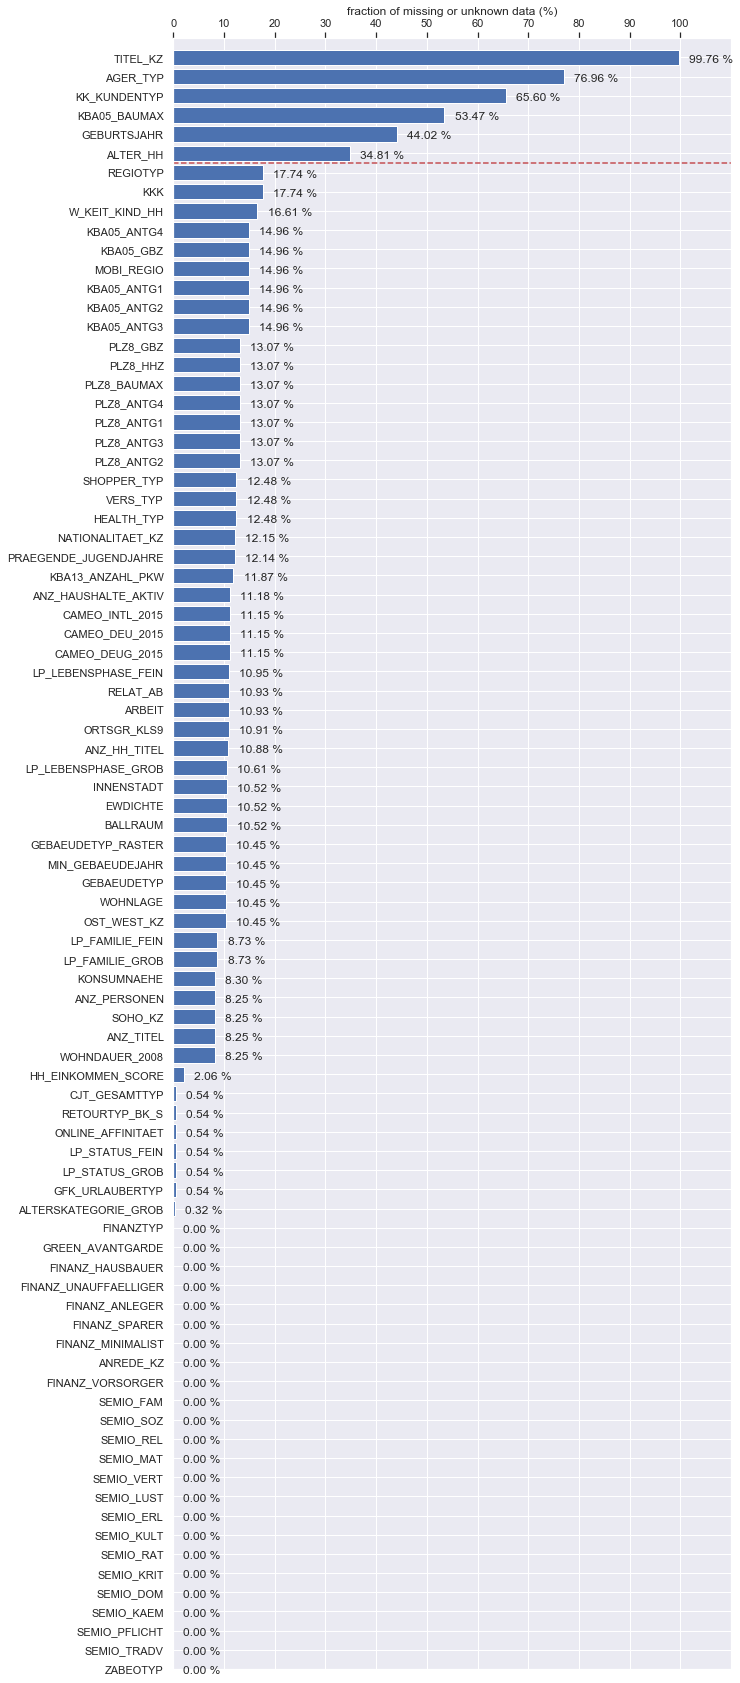

In [982]:
# Perform an assessment of how much missing data there is in each column of the dataset.

# total rows
n_entries = azdias.shape[0]

# missing data per column after replacing missing and unknown values
missing_after_cleaning = n_entries - azdias_replaced.count()

# fraction of missing data
fraction_missing = missing_after_cleaning/n_entries

# sort missing data fraction in descending order
idx = np.argsort(fraction_missing)

# visiualize missing data using barh
sns.set()
plt.figure(figsize=(10,30))
plt.barh(range(1,86), fraction_missing[idx]*100.0,
         height=0.8, tick_label=azdias_replaced.columns[idx])
plt.hlines(79.5, xmin=0.0, xmax=110.0, colors='r', linestyles='--')
plt.xticks(np.linspace(0,100,11))
plt.xlim(0.0, 110.0)
plt.ylim(1, 86)
plt.xlabel('fraction of missing or unknown data (%)')
ax = plt.gca()
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
# add values to the bars
for i, val in enumerate(fraction_missing[idx]):
    plt.text(val*100.0+2.0, i+0.75, '%.2f %%' % (val*100))

> * in six columns more than 30% of the values are missing or unknown
    * `TITEL_KZ`, `AGER_TYP`, `KK_KUNDENTYP`, `KBA05_BAUMAX`, `GEBURTSJAHR`, and `ALTER_HH`
* these columns will be dropped from the dataset

In [287]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
drop_columns_missing = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']
azdias_cleaned = azdias_replaced.drop(drop_columns_missing, axis=1)

# also drop columns from feat_info by assigning 'attribute' as index
feat_info_cleaned = feat_info.set_index('attribute').drop(drop_columns_missing, axis=0).reset_index()

print(azdias_cleaned.shape)

(891221, 79)


Text(0.5, 1, 'distribution of missing values (NaN) in the data: dark blue = NaN')

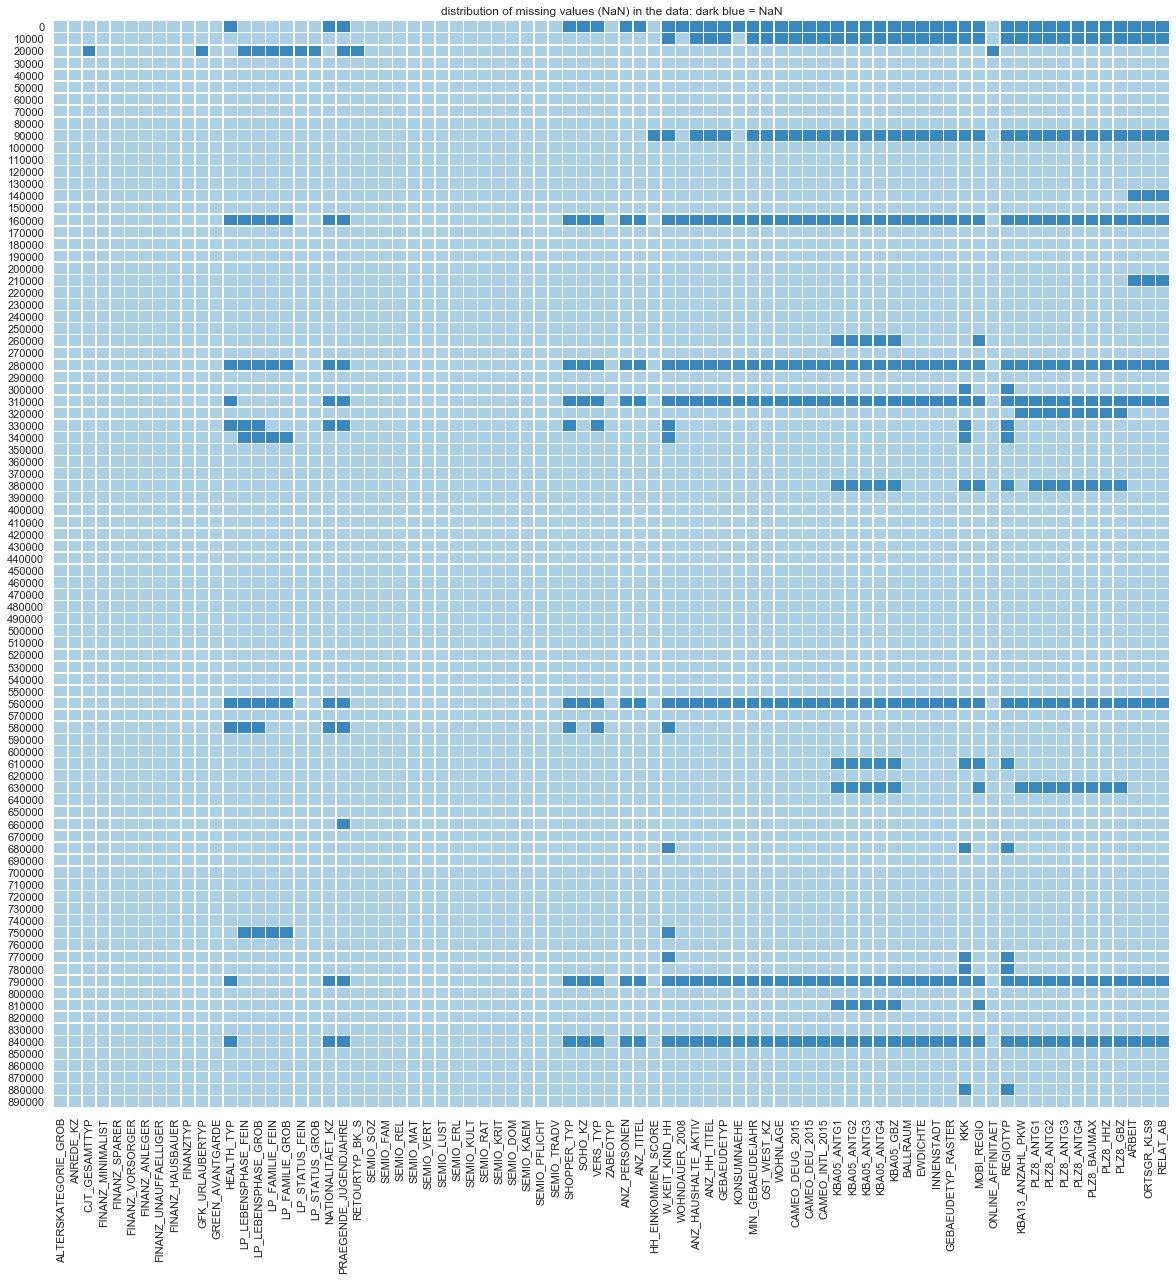

In [288]:
# Investigate patterns in the amount of missing data in each column.
plt.figure(figsize=(20,20))
sns.heatmap(azdias_cleaned.iloc[::10000, :].isnull(), cmap=sns.color_palette('Blues', 2), cbar=False, linewidth=0.5)
plt.title('distribution of missing values (NaN) in the data: dark blue = NaN')

#### Discussion 1.1.2: Assess Missing Data in Each Column
> Initially the dataset contained 6% (4,896,838) missing values. After replacement of values indicating unknown information, the dataset contained 11% (8,737,929) missing values. Thus, there are still enough data points available for further analysis.

> Further, six columns (`TITEL_KZ`, `AGER_TYP`, `KK_KUNDENTYP`, `KBA05_BAUMAX`, `GEBURTSJAHR`, and `ALTER_HH`) were identified to have more than 30% of values missing. These columns were removed from the dataset. `TTITEL_KZ` even had more than 99% missing values. This is reasonable as only a small percentage of individuals in the population hold academic titles. For future studies it would be good to encode a category 'none' for `TITEL_KZ` as it might provide valuable information.

> An analysis of the distribution of the missing values in the dataset, revealed that most columns in a row contain missing values if the column `HEALTH_TYP` contains a missing value. This might indicate that the dataset was compiled from different sources. In addition, the missing information contains personal, private information about health, family, and living conditions that might not want to be shared by all individuals in a survey.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [983]:
# How much data is missing in each row of the dataset?
missing_in_row = azdias_cleaned.isnull().sum(axis=1)
print(missing_in_row.head(10))

0    43
1     0
2     0
3     7
4     0
5     0
6     0
7     0
8     0
9     0
dtype: int64


Text(0, 0.5, 'cumulative fraction of rows')

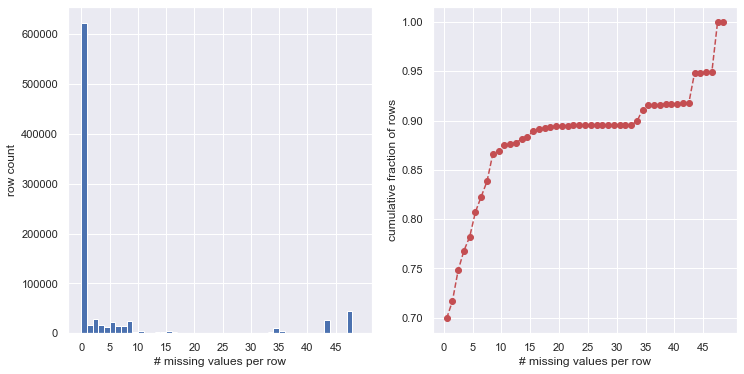

In [984]:
# plot distribution of number of missing values in rows
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
counts, bins, patches = plt.hist(missing_in_row, bins=49, align='mid')
plt.xticks(range(0,50,5))
plt.xlabel('# missing values per row')
plt.ylabel('row count')
# plot cumulative distribution
plt.subplot(1, 2, 2)
bins_centers = bins[0:-1] + 0.5*(bins[1:] - bins[0:-1])
plt.plot(bins_centers, counts.cumsum()/n_entries, 'ro--')
plt.xticks(range(0,50,5))
plt.xlabel('# missing values per row')
plt.ylabel('cumulative fraction of rows')

In [990]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# max. threshold for incomplete columns
comp_threshold = 0  # choose only complete rows

# divide dataset into two subsets
azdias_comp = azdias_cleaned.loc[azdias_cleaned.isnull().sum(axis=1) <= comp_threshold]
azdias_incomp = azdias_cleaned.loc[azdias_cleaned.isnull().sum(axis=1) > comp_threshold]

print('# complete rows: %i' % azdias_comp.shape[0])
print('# incomplete rows: %i' % azdias_incomp.shape[0])

# complete rows: 623209
# incomplete rows: 268012


In [991]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# function to plot distributions from complete and incomplete dataset
def plot_distributions(column, complete_data, incomplete_data):
    
    plt.figure(figsize=(12,4))
    plt.subplot(1, 2, 1)
    sns.countplot(data=complete_data, x=column, color=sns.color_palette()[0])
    plt.title('complete dataset')
    
    plt.subplot(1, 2, 2)
    sns.countplot(data=incomplete_data, x=column, color=sns.color_palette()[0])
    plt.title('incomplete dataset')

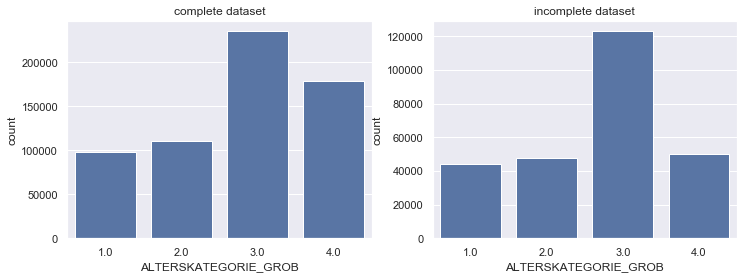

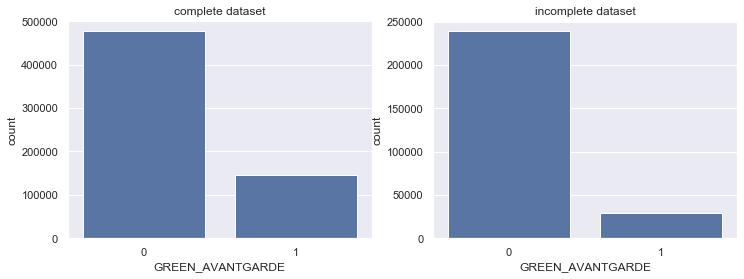

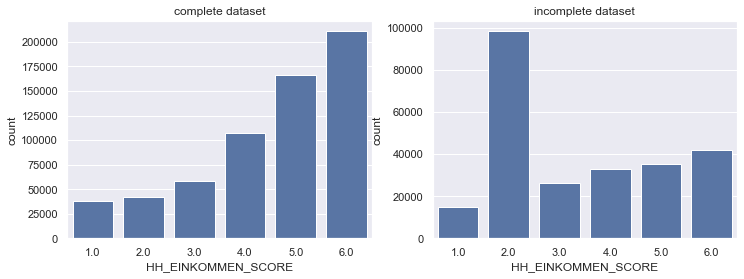

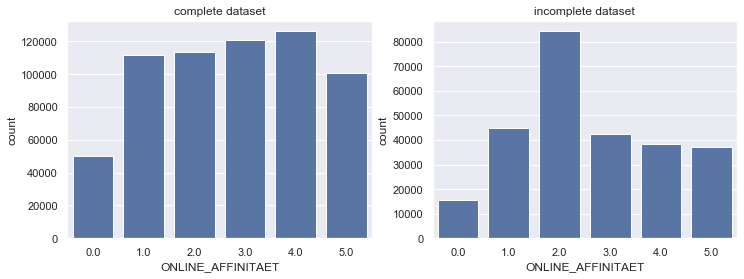

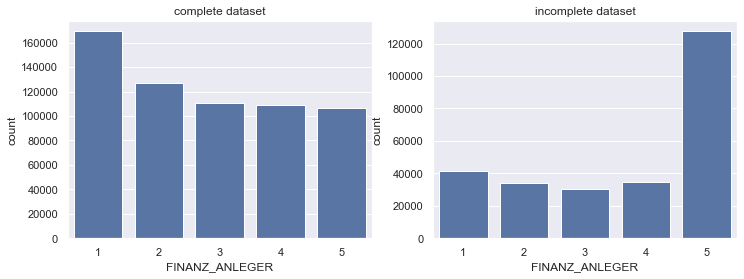

In [992]:
# select columns with only few missing values
compare_columns = ['ALTERSKATEGORIE_GROB', 'GREEN_AVANTGARDE', 'HH_EINKOMMEN_SCORE',
                   'ONLINE_AFFINITAET', 'FINANZ_ANLEGER']

for col in compare_columns:
    plot_distributions(col, azdias_comp, azdias_incomp)

#### Discussion 1.1.3: Assess Missing Data in Each Row

> In total, 268,012 rows or 30% of the rows are incomplete. Roughly 10% of the rows lack more than 30 values. In conclusion, 70% of the rows are complete. Therefore, only the complete rows are considered here for futher analysis as they provide enough valid data.

> The analysis of five selected features that are almost complete in both, the complete and incomplete, datasets shows some differences in the distribution of the features:
* `ALTERSKATEGORIE_GROB`: the complete dataset contains more older persons than the incomplete dataset; the other age groups are represented equally well in both datasets
* `GREEN_AVANTGARDE`: members of environmental parties/organizations are represented slighty more in the complete dataset
* `HH_EINKOMMEN_SCORE`: more average and lower household incomes are represented in the complete dataset, while the incomplete dataset contains a significant fraction of very high incomes
* `ONLINE_AFFINITAET`: the complete data shows a uniform distribution of online affinity; only persons with low online affinity are represented less in the complete dataset; the incomplete dataset shows a Gaussian distribution of around 'middle' online affinity
* `FINANZ_ANLEGER`: compared to the incomplete dataset, investors are represented more in the complete dataset. Moderate levels of investors are almost equally distributed in both datasets

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [993]:
# How many features are there of each data type?
feat_info_cleaned.type.value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [994]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical_list = feat_info_cleaned[feat_info_cleaned.type == 'categorical'].attribute.tolist()

# loop through features and determine which ones are binary, i.e., two values only
binary_list =[]
multilevel_list = []
for col in categorical_list:
    if azdias_comp[col].value_counts().shape[0] == 2:
        binary_list.append(col)
    else:
        multilevel_list.append(col)

print('%i binary features:' % len(binary_list), binary_list)
print('%i multi-level features:' % len(multilevel_list), multilevel_list)

5 binary features: ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']
13 multi-level features: ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [995]:
# Re-encode categorical variable(s) to be kept in the analysis.
from sklearn.preprocessing import OneHotEncoder

# a. re-encoding OST_WEST_KZ from string to binary (W=0, O=1)
azdias_comp.replace({'OST_WEST_KZ': {'W': 0, 'O': 1}}, inplace=True)
print(azdias_comp['OST_WEST_KZ'].value_counts())

0    490879
1    132330
Name: OST_WEST_KZ, dtype: int64


/Users/larskiewidt/anaconda3/envs/datasci/lib/python3.7/site-packages/pandas/core/generic.py:6517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  regex=regex)


In [996]:
# b. encode categorical features to be kept
cat_features_kept = ['CJT_GESAMTTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB']

# implement OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoded_cat_values = encoder.fit_transform(azdias_comp[cat_features_kept])

encoded_cat_cols = ['CJT_GESAMTTYP_1', 'CJT_GESAMTTYP_2', 'CJT_GESAMTTYP_3', 'CJT_GESAMTTYP_4', 'CJT_GESAMTTYP_5',
                    'CJT_GESAMTTYP_6',
                    'LP_FAMILIE_GROB_1', 'LP_FAMILIE_GROB_2', 'LP_FAMILIE_GROB_3', 'LP_FAMILIE_GROB_4', 'LP_FAMILIE_GROB_5',
                    'LP_STATUS_GROB_1', 'LP_STATUS_GROB_2', 'LP_STATUS_GROB_3', 'LP_STATUS_GROB_4', 'LP_STATUS_GROB_5']

# create dataframe for encoded features
df_cat_encoded = pd.DataFrame(encoded_cat_values, columns=encoded_cat_cols, index=azdias_comp.index)

# join encoded features to cleaned dataset and remove original categorical colums
azdias_encoded = azdias_comp.join(df_cat_encoded)
azdias_encoded.drop(cat_features_kept, axis=1, inplace=True)

# assign categorical features to be dropped
cat_features_dropped = ['FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN',
                        'LP_STATUS_FEIN', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP',
                        'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']

# drop non-selected categorical features
azdias_encoded.drop(cat_features_dropped, axis=1, inplace=True)
azdias_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623209 entries, 1 to 891220
Data columns (total 82 columns):
ALTERSKATEGORIE_GROB     623209 non-null float64
ANREDE_KZ                623209 non-null int64
FINANZ_MINIMALIST        623209 non-null int64
FINANZ_SPARER            623209 non-null int64
FINANZ_VORSORGER         623209 non-null int64
FINANZ_ANLEGER           623209 non-null int64
FINANZ_UNAUFFAELLIGER    623209 non-null int64
FINANZ_HAUSBAUER         623209 non-null int64
GREEN_AVANTGARDE         623209 non-null int64
HEALTH_TYP               623209 non-null float64
LP_LEBENSPHASE_FEIN      623209 non-null float64
LP_LEBENSPHASE_GROB      623209 non-null float64
PRAEGENDE_JUGENDJAHRE    623209 non-null float64
RETOURTYP_BK_S           623209 non-null float64
SEMIO_SOZ                623209 non-null int64
SEMIO_FAM                623209 non-null int64
SEMIO_REL                623209 non-null int64
SEMIO_MAT                623209 non-null int64
SEMIO_VERT               623209

#### Discussion 1.2.1: Re-Encode Categorical Features
> After removing missing values, there were 18 categorical featueres left in the dataset: 5 binary features, and 13 multi-level features. The `OST_WEST_KZ` feature was econded using strings and hence was re-encoded to binary numerical values (W=0, O=1). From the 13 multi-level features, 3 features were kept and re-encoded (see below). The other multi-level features were dropped because their information is already captured in other features, is too fine-grained for this analysis, or are only partially linked to consumer behavior on first glance (see list below).

> **CATEGORICAL FEATURES KEPT**
* `CJT_GESAMTTYP`: contains useful information about response to advertisment, which is key to this analysis
* `LP_FAMILIE_GROB`: contains useful information about family situation
* `LP_STATUS_GROB`: contains useful information about income/wealth

> **CATEGORICAL FEATURES DROPPED**
* `FINANZTYP`: already captured in other `FINANZ_*` features
* `GFK_URLAUBERTYP`: not related to consumer segement on first glance
* `LP_FAMILIE_FEIN`: very fine grained information; not considered in preliminary analysis; captured in corresponding `*_GROB` feature
* `LP_STATUS_FEIN`: very fine grained information; not considered in preliminary analysis; captured in corresponding `*_GROB` feature
* `NATIONALITAET_KZ`: seems to be concluded from name; no reliable information about nationality
* `VERS_TYP`: only indirect link to customer behaviour at first glance
* `ZABEOTYP`: partially captured in other features
* `GEBAEUDETYP`: only indirect link to customer behaviour at first glance
* `CAMEO_DEUG_2015`: already captured in `CAMEO_INTL_2015`
* `CAMEO_DEU_2015`: fine grained version of the above feature; too detailed at this stage

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [997]:
# Find all mixed-type features
feat_info_cleaned[feat_info_cleaned.type == 'mixed']

,attribute,information_level,type,missing_or_unknown
13,LP_LEBENSPHASE_FEIN,person,mixed,[0]
14,LP_LEBENSPHASE_GROB,person,mixed,[0]
20,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
51,WOHNLAGE,building,mixed,[-1]
54,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
73,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [998]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# create new dataframe for engineered variables
azdias_eng = pd.DataFrame(index=azdias_encoded.index)
azdias_eng['PRAEGENDE_JUGENDJAHRE'] = azdias_encoded['PRAEGENDE_JUGENDJAHRE'].astype(str)

replace_decades = {'1.0': 1940, '2.0': 1940, '3.0': 1950, '4.0': 1950, '5.0': 1960, '6.0': 1960, '7.0': 1960,
                   '8.0': 1970, '9.0': 1970, '10.0': 1980, '11.0': 1980, '12.0': 1980, '13.0': 1980,
                   '14.0': 1990, '15.0': 1990}

replace_avantgarde = {'1.0': 0, '2.0': 1, '3.0': 0, '4.0': 1, '5.0': 0, '6.0': 1, '7.0': 1,
                      '8.0': 0, '9.0': 1, '10.0': 0, '11.0': 1, '12.0': 0, '13.0': 1,
                      '14.0': 0, '15.0': 1}

azdias_eng['DECADE'] = azdias_eng.replace({'PRAEGENDE_JUGENDJAHRE': replace_decades})
azdias_eng['MAIN_AVANT'] = 0  # need to set this first to avoid KeyError in pandas
azdias_eng['MAIN_AVANT'] = azdias_eng.replace({'PRAEGENDE_JUGENDJAHRE': replace_avantgarde})
print(azdias_eng.head(10))
print(azdias_eng.info())

   PRAEGENDE_JUGENDJAHRE  DECADE  MAIN_AVANT
1                   14.0    1990           0
2                   15.0    1990           1
4                    8.0    1970           0
5                    3.0    1950           0
6                   10.0    1980           0
7                    8.0    1970           0
8                   11.0    1980           1
9                   15.0    1990           1
10                   3.0    1950           0
19                   9.0    1970           1
<class 'pandas.core.frame.DataFrame'>
Int64Index: 623209 entries, 1 to 891220
Data columns (total 3 columns):
PRAEGENDE_JUGENDJAHRE    623209 non-null object
DECADE                   623209 non-null int64
MAIN_AVANT               623209 non-null int64
dtypes: int64(2), object(1)
memory usage: 39.0+ MB
None


In [999]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_eng['CAMEO_INTL_2015'] = azdias_encoded['CAMEO_INTL_2015'].astype(str)
azdias_eng['FAMILY_WEALTH'] = azdias_eng['CAMEO_INTL_2015'].apply(lambda x: int(x[0]))
azdias_eng['FAMILY_TYPE'] = azdias_eng['CAMEO_INTL_2015'].apply(lambda x: int(x[1]))
azdias_eng.head(10)

,PRAEGENDE_JUGENDJAHRE,DECADE,MAIN_AVANT,CAMEO_INTL_2015,FAMILY_WEALTH,FAMILY_TYPE
1,14.0,1990,0,51,5,1
2,15.0,1990,1,24,2,4
4,8.0,1970,0,43,4,3
5,3.0,1950,0,54,5,4
6,10.0,1980,0,22,2,2
7,8.0,1970,0,14,1,4
8,11.0,1980,1,13,1,3
9,15.0,1990,1,15,1,5
10,3.0,1950,0,51,5,1
19,9.0,1970,1,34,3,4


In [1000]:
# Investigate "WOHNLAGE" to engineer a binary rural feature
azdias_eng['WOHNLAGE'] = azdias_encoded['WOHNLAGE']
azdias_eng['RURAL'] = azdias_encoded['WOHNLAGE'].map({1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1})
azdias_eng.head(10)

,PRAEGENDE_JUGENDJAHRE,DECADE,MAIN_AVANT,CAMEO_INTL_2015,FAMILY_WEALTH,FAMILY_TYPE,WOHNLAGE,RURAL
1,14.0,1990,0,51,5,1,4.0,0.0
2,15.0,1990,1,24,2,4,2.0,0.0
4,8.0,1970,0,43,4,3,3.0,0.0
5,3.0,1950,0,54,5,4,7.0,1.0
6,10.0,1980,0,22,2,2,5.0,0.0
7,8.0,1970,0,14,1,4,1.0,0.0
8,11.0,1980,1,13,1,3,1.0,0.0
9,15.0,1990,1,15,1,5,7.0,1.0
10,3.0,1950,0,51,5,1,5.0,0.0
19,9.0,1970,1,34,3,4,1.0,0.0


In [1001]:
# remove mixed features from engineered features data frame
azdias_eng.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015', 'WOHNLAGE'], axis=1, inplace=True)
print(azdias_eng.head(10))
print(azdias_eng.info())

    DECADE  MAIN_AVANT  FAMILY_WEALTH  FAMILY_TYPE  RURAL
1     1990           0              5            1    0.0
2     1990           1              2            4    0.0
4     1970           0              4            3    0.0
5     1950           0              5            4    1.0
6     1980           0              2            2    0.0
7     1970           0              1            4    0.0
8     1980           1              1            3    0.0
9     1990           1              1            5    1.0
10    1950           0              5            1    0.0
19    1970           1              3            4    0.0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 623209 entries, 1 to 891220
Data columns (total 5 columns):
DECADE           623209 non-null int64
MAIN_AVANT       623209 non-null int64
FAMILY_WEALTH    623209 non-null int64
FAMILY_TYPE      623209 non-null int64
RURAL            623205 non-null float64
dtypes: float64(1), int64(4)
memory usage: 48.5 MB
None

#### Discussion 1.2.2: Engineer Mixed-Type Features

> From the 6 mixed-type features, 5 new features have been engineered (see below). The other mixed type features were dropped as their information is already covered by other features (see list below).

> **NEW ENGINEERED FEATURES**
* `DECACDE`: defining youth decade
* `MAIN_AVANT`: whether part of mainstream or avantgarde movement
* `FAMILY_WEALTH`: wealth of the family
* `FAMILY_TYPE`: type of family situation
* `RURAL`: if person is living in rural environment
    * `RURAL` still contained 4 missing values (NaN) because there were 4 original values in `WOHNLAGE` that contained a 0 (= no score calculated); these values were not replaced previously because 0 was not in the list of missing/unknown value codes; these were lines were therefore also dropped from the dataset.

> **DROPPED MIXED-TYPE FEATURES**
* `PRAEGENDE_JUGENDJAHR`: information now partially in new engineered features
* `CAMEO_INTL_2015`: information now in new engineered features
* `LP_LEBENSPHASE_FEIN/_GROB`: information form both features is contained in other features as well; the information is very fine grained in these two features
* `WOHNLAGE`: information now partially in new engineered features
* `PLZ8_BAUMAX`: information is partially covered by other features; information might only be marginally relevant for this analysis

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [1002]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# combine cleand dataset with engineered features
azdias_final = azdias_encoded.join(azdias_eng)

# remove mixed-type features
mixed_features = feat_info_cleaned[feat_info_cleaned.type == 'mixed'].attribute.tolist()
azdias_final.drop(mixed_features, axis=1, inplace=True)

# remove empty lines (because of RURAL engineered feature)
azdias_final.dropna(inplace=True)

azdias_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623205 entries, 1 to 891220
Data columns (total 81 columns):
ALTERSKATEGORIE_GROB     623205 non-null float64
ANREDE_KZ                623205 non-null int64
FINANZ_MINIMALIST        623205 non-null int64
FINANZ_SPARER            623205 non-null int64
FINANZ_VORSORGER         623205 non-null int64
FINANZ_ANLEGER           623205 non-null int64
FINANZ_UNAUFFAELLIGER    623205 non-null int64
FINANZ_HAUSBAUER         623205 non-null int64
GREEN_AVANTGARDE         623205 non-null int64
HEALTH_TYP               623205 non-null float64
RETOURTYP_BK_S           623205 non-null float64
SEMIO_SOZ                623205 non-null int64
SEMIO_FAM                623205 non-null int64
SEMIO_REL                623205 non-null int64
SEMIO_MAT                623205 non-null int64
SEMIO_VERT               623205 non-null int64
SEMIO_LUST               623205 non-null int64
SEMIO_ERL                623205 non-null int64
SEMIO_KULT               623205 non-n

In [1003]:
feat_info_cleaned['type'].value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

In [1004]:
azdias_final.shape

(623205, 81)

> **SUMMARY**
The final dataframe should contain 49 ordinal features, 6 numeric features, 5 binary features, 5 engineered features, and 16 columns for 3 categorical features. In total there are 49 + 6 + 5 + 5 + 16 = 81 columns in the dataset. The final cleaned dataset has thus 623,205 rows and 81 columns.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [1005]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # create copy of dataframe
    df_cleaned = df.copy()
    
    
    # 1. replace missing and unknown values by NaN, and remove columns and lines with many missing values
    
    # list of missing and unknown codes     
    missing_codes_list = [[-1, 0], [-1, 0, 9], [-1, 0], [0], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [0], [], [],
                          [-1, 0], [0], [0], [0], [0], [0], [0], [-1, 0], [-1, 0], [0], [-1, 9], [-1, 9], [-1, 9],
                          [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1, 9],
                          [-1, 9], [-1], [-1], [-1, 0], [-1], [-1, 9], [0], [], [], [-1, 0], [-1], [-1, 0], [-1, 0],
                          [0], [], [-1, 0], [], [0], [-1], [-1], ['-1', 'X'], ['XX'], ['-1', 'XX'], [-1], [-1], [-1],
                          [-1], [-1, 0], [-1, 0], [-1], [-1], [-1], [], [-1, 0], [], [], [-1, 0], [], [-1], [-1],
                          [-1], [-1], [-1, 0], [-1], [-1], [-1, 9], [-1, 0], [-1, 9]]
    
    # loop over columns and replace missing/unknown data skipping columns without missing/unknown codes
    for i, col in enumerate(df_cleaned.columns):
        if missing_codes_list[i] != []:
            df_cleaned[col] = df[col].replace(missing_list[i], np.NaN)
    
    # drop columns with many missing values
    drop_columns_missing = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']
    df_cleaned.drop(drop_columns_missing, axis=1, inplace=True)
    
    # remove lines with empty values
    df_cleaned.dropna(inplace=True)
    

    # 2. re-encoding features
    
    # re-encoding OST_WEST_KZ from string to binary (W=0, O=1) inplace
    df_cleaned.replace({'OST_WEST_KZ': {'W': 0, 'O': 1}}, inplace=True)
    
    # re-encoding categorical features    
    # implement OneHotEncoder
    keep_cat_features = ['CJT_GESAMTTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB']
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    encoded_cat_values = encoder.fit_transform(df_cleaned[keep_cat_features])

    encoded_cat_cols = ['CJT_GESAMTTYP_1', 'CJT_GESAMTTYP_2', 'CJT_GESAMTTYP_3', 'CJT_GESAMTTYP_4', 'CJT_GESAMTTYP_5',
                        'CJT_GESAMTTYP_6',
                        'LP_FAMILIE_GROB_1', 'LP_FAMILIE_GROB_2', 'LP_FAMILIE_GROB_3', 'LP_FAMILIE_GROB_4', 'LP_FAMILIE_GROB_5',
                        'LP_STATUS_GROB_1', 'LP_STATUS_GROB_2', 'LP_STATUS_GROB_3', 'LP_STATUS_GROB_4', 'LP_STATUS_GROB_5']

    # create dataframe for encoded features
    df_cat_encoded = pd.DataFrame(encoded_cat_values, columns=encoded_cat_cols, index=df_cleaned.index)
    
    # join encoded features to cleaned dataset and remove original categorical colums
    df_cleaned = df_cleaned.join(df_cat_encoded)
    
    
    # 3. engineering features
    
    # create new dataframe for engineered variables
    df_eng = pd.DataFrame(index=df_cleaned.index)
    df_eng['PRAEGENDE_JUGENDJAHRE'] = df_cleaned['PRAEGENDE_JUGENDJAHRE'].astype(str)

    replace_decades = {'1.0': 1940, '2.0': 1940, '3.0': 1950, '4.0': 1950, '5.0': 1960, '6.0': 1960, '7.0': 1960,
                       '8.0': 1970, '9.0': 1970, '10.0': 1980, '11.0': 1980, '12.0': 1980, '13.0': 1980,
                       '14.0': 1990, '15.0': 1990}

    replace_avantgarde = {'1.0': 0, '2.0': 1, '3.0': 0, '4.0': 1, '5.0': 0, '6.0': 1, '7.0': 1,
                          '8.0': 0, '9.0': 1, '10.0': 0, '11.0': 1, '12.0': 0, '13.0': 1,
                          '14.0': 0, '15.0': 1}

    df_eng['DECADE'] = df_eng.replace({'PRAEGENDE_JUGENDJAHRE': replace_decades})
    df_eng['MAIN_AVANT'] = 0  # need to set this first to avoid KeyError in pandas
    df_eng['MAIN_AVANT'] = df_eng.replace({'PRAEGENDE_JUGENDJAHRE': replace_avantgarde})
    
    df_eng['CAMEO_INTL_2015'] = df_cleaned['CAMEO_INTL_2015'].astype(str)
    df_eng['FAMILY_WEALTH'] = df_eng['CAMEO_INTL_2015'].apply(lambda x: int(x[0]))
    df_eng['FAMILY_TYPE'] = df_eng['CAMEO_INTL_2015'].apply(lambda x: int(x[1]))
    
    df_eng['WOHNLAGE'] = df_cleaned['WOHNLAGE']
    df_eng['RURAL'] = df_cleaned['WOHNLAGE'].map({1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1})

    df_eng.drop(['PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015'], axis=1, inplace=True)
    
    # add engineered variables
    df_cleaned = df_cleaned.join(df_eng)
    
    # drop other categorical and mixed-type features
    drop_mixed_features = ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE',
                           'CAMEO_INTL_2015', 'PLZ8_BAUMAX']
    
    drop_cat_features = ['FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN',
                         'LP_STATUS_FEIN', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP',
                         'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']

    drop_columns =  keep_cat_features + drop_mixed_features + drop_cat_features
    
    df_cleaned.drop(drop_columns, axis=1, inplace=True)
    
    # remove lines with empty values
    df_cleaned.dropna(inplace=True)

    # Return the cleaned dataframe.
    return df_cleaned
    

In [1006]:
# test clean_data()
data_final = clean_data(azdias)

df_check = data_final != azdias_final
df_check.sum().sum()

0

> **SUMMARY** The implemented function delivers the same dataset as the original data wrangling.

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [1007]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
data_final.isnull().sum().sum()


0

In [1008]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_std = scaler.fit_transform(data_final)

### Discussion 2.1: Apply Feature Scaling

> The final dataset contains no NaN values. Imputation was not needed and a standard scaler was applied directly to the data.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [1009]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

pca = PCA()
data_pca = pca.fit_transform(data_std)


In [1010]:
# implement function to plot explained variance from PCA
def plot_pca(pca, limit=20):
    
    n_PC = len(pca.explained_variance_ratio_)
    idx_PC = range(1, n_PC+1)
    var_PC = pca.explained_variance_ratio_
    cum_var_PC = np.cumsum(var_PC)
    
    plt.figure(figsize=(15,10))
    plt.subplot(2, 1, 1)
    plt.bar(idx_PC[:limit], var_PC[:limit], linewidth=0.0)
    plt.xticks(range(1,limit+1))
    plt.ylim(0.0, np.around(np.max(var_PC), decimals=1))
    for i in range(0, limit):
        plt.annotate('%.1f%%' % (100.0*var_PC[i]), (i+1, var_PC[i]+0.01), ha='center', rotation=90.0, weight='bold')
    plt.xlabel('principal component')
    plt.ylabel('explained variance ratio')
    
    plt.subplot(2, 1, 2)
    plt.plot(idx_PC, cum_var_PC, 'ro--')
    plt.hlines([0.5, 0.68, 0.8, 0.95], xmin=1, xmax=n_PC, linestyles='--')
    plt.ylim(ymin=0.0)
    plt.xlabel('principal component')
    plt.ylabel('cumulative explained variance ratio')
    plt.annotate('50%', (1, 0.52), weight='bold')
    plt.annotate('68%', (1, 0.70), weight='bold')
    plt.annotate('80%', (1, 0.82), weight='bold')
    plt.annotate('95%', (1, 0.97), weight='bold')

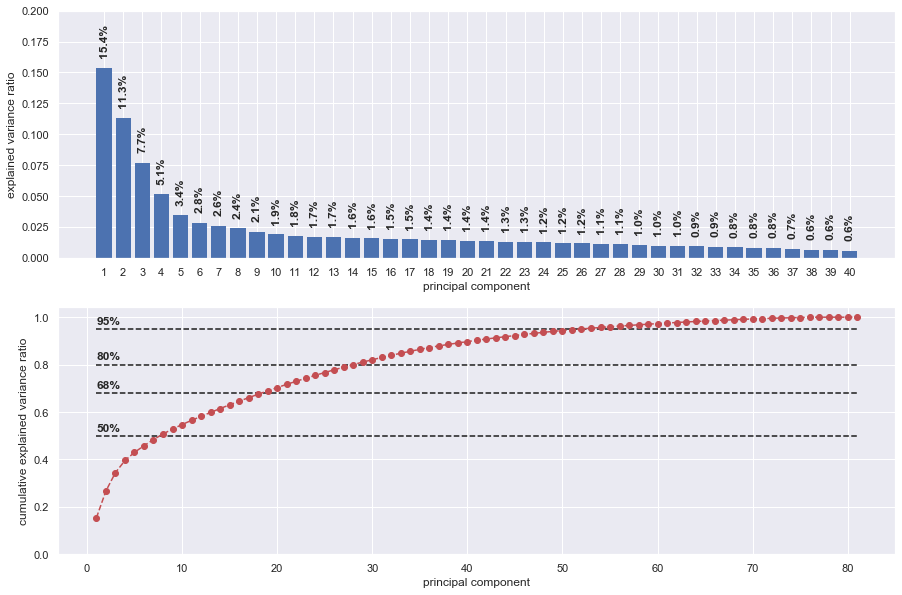

In [1011]:
# Investigate the variance accounted for by each principal component.
plot_pca(pca, limit=40)

In [1012]:
cum_var_PC = np.cumsum(pca.explained_variance_ratio_)

for i in range(20):
    print('%i PCs: %.1f%% variance explained' % (i+1, cum_var_PC[i]*100.0))

1 PCs: 15.4% variance explained
2 PCs: 26.7% variance explained
3 PCs: 34.4% variance explained
4 PCs: 39.6% variance explained
5 PCs: 43.0% variance explained
6 PCs: 45.8% variance explained
7 PCs: 48.4% variance explained
8 PCs: 50.7% variance explained
9 PCs: 52.8% variance explained
10 PCs: 54.7% variance explained
11 PCs: 56.5% variance explained
12 PCs: 58.2% variance explained
13 PCs: 59.8% variance explained
14 PCs: 61.5% variance explained
15 PCs: 63.0% variance explained
16 PCs: 64.6% variance explained
17 PCs: 66.0% variance explained
18 PCs: 67.5% variance explained
19 PCs: 68.9% variance explained
20 PCs: 70.3% variance explained


In [1013]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_20 = PCA(n_components=20)
data_pca_20 = pca_20.fit_transform(data_std)

### Discussion 2.2: Perform Dimensionality Reduction

> * first 2 PCs caputre more than 25% of the variance
* first 4 PCs each capture more than 5% of the variance
* all PCs after 10 individually only capture less than 2% of the variance 
* 50% of the variance can be captured with 8 PCs
* 70% of the variance can be captured with 20 PCs
    * therefore, 20 PCs are used in the subsequent cluster analysis
    * dimensionality reduction by a factor of 4 from 81 to 20 features

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [1014]:
n_components = pca_20.components_.shape[0]
df_pca = pd.DataFrame(pca_20.components_, columns=data_final.columns,
                      index=['PC %i' % i for i in range(1, n_components+1)])

df_pca['EXPLAINED_VARIANCE_RATIO'] = pca_20.explained_variance_ratio_.reshape((n_components, -1))

In [1015]:
# implement function to analyze and plot feature weights in PC
def plot_pca_weights(df, component, threshold=0.1):
    
    # extract explained variance and weights
    explained_variance = float(df.iloc[component-1, -1])
    weights = df.iloc[component-1, 0:-1].values
    features = np.array((df.columns[0:-1]))

    # sort values and features by weight
    idx = np.argsort(-1.0*weights)
    weights_sorted = weights[idx]
    features_sorted = features[idx]

    
    # reduce to features with weights higher +-0.1
    weights_pos = np.trim_zeros(np.where(weights_sorted >= threshold, weights_sorted, 0.0))
    weights_neg = np.trim_zeros(np.where(weights_sorted <= -1.0*threshold, weights_sorted, 0.0))
    weights_main = np.hstack((weights_pos, weights_neg))

    n_pos = len(weights_pos)
    n_neg = len(weights_neg)
    n_main = n_pos + n_neg

    features_main = np.hstack((features_sorted[0:n_pos], features_sorted[-n_neg:]))
    feature_idx = range(1,n_main+1)
    
    
    # plot
    plt.figure(figsize=(15,10))
    ax = plt.gca()
    plt.bar(feature_idx, weights_main, align='center', linewidth=0.0)
    plt.xticks(feature_idx)
    ax.set_xticklabels([])
    for i in range(n_pos):
        plt.annotate('%s' % features_main[i], (i+1, -0.01), rotation=90, ha='center', va='top', weight='bold')
        plt.annotate('%.1f%%' % (weights_main[i]*100.0), (i+1, weights_main[i]+0.01),
                     rotation=90, ha='center', va='bottom', weight='bold')
    
    for i in range(n_neg):
        plt.annotate('%s' % features_main[n_pos+i], (n_pos+i+1, 0.01), rotation=90, ha='center', va='bottom', weight='bold')
        plt.annotate('%.1f%%' % (weights_main[n_pos+i]*100.0), (n_pos+i+1, weights_main[n_pos+i]-0.01),
                     rotation=90, ha='center', va='top', weight='bold')
    
    plt.ylim(ymin=np.around(np.min(weights_main), 1)-0.1, ymax=np.around(np.max(weights_main), 1)+0.1)
    plt.title('principal component %i | %.1f%% explained variance | weights larger 10%% shown' % (component, explained_variance*100.0),
              weight='bold', fontsize='large')

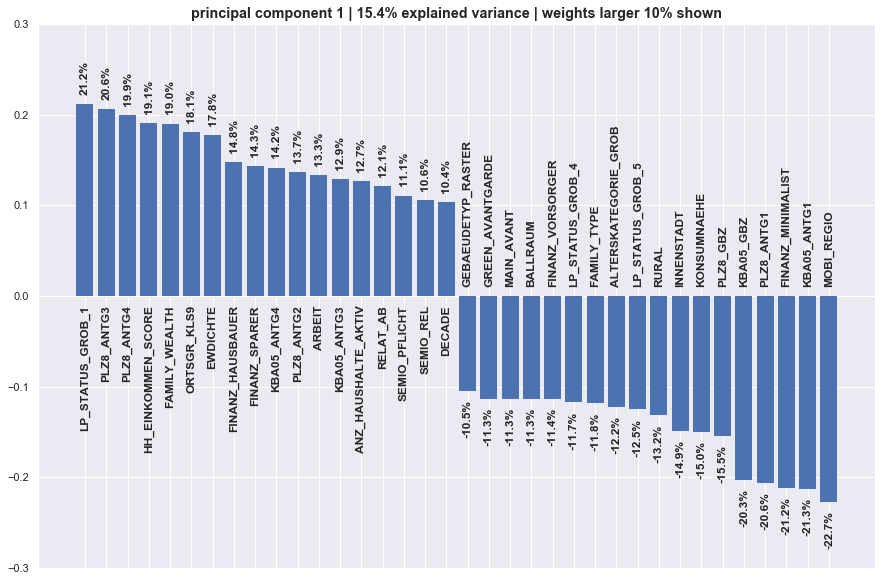

In [1016]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
plot_pca_weights(df_pca, 1)

> **PC1 analysis**

> **high positive weight**
* `LP_STATUS_GROB_1`: categorical, low-income earners
* `PLZ8_ANTG3`: ordinal, high share of 6-10 family houses
* `PLZ8_ANTG4`: ordinal, high share of 10+ family houses
* `HH_EINKOMMEN_SCORE`: ordinal, very low to low incomes
* `FAMILY_WEALTH`: categorical, less affluent to poor households
* `ORTSGR_KLS9`: ordinal, larger cities/communities
* `EWDICHTE`: ordinal, high household density

> **high negative weight**
* `MOBI_REGIO`: ordinal, high movement rate
* `KBA05_ANTG1`: ordinal, low share of 1-2 family households around
* `FINANZ_MINIMALIST`: ordinal, no finanical interest
* `PLZ8_ANTG1`: ordinal, low share of 1-2 family households
* `KBA05_GBZ`: ordinal, few buildings around

> **Analysis:** Individuals with high PC1 values have generally a **low income/wealth**, **minimal finanical interest**, live in **large, polulated areas** with **few 10+ family buildings**, and **move often**. They can be considered as the **poor metropilitan population**.

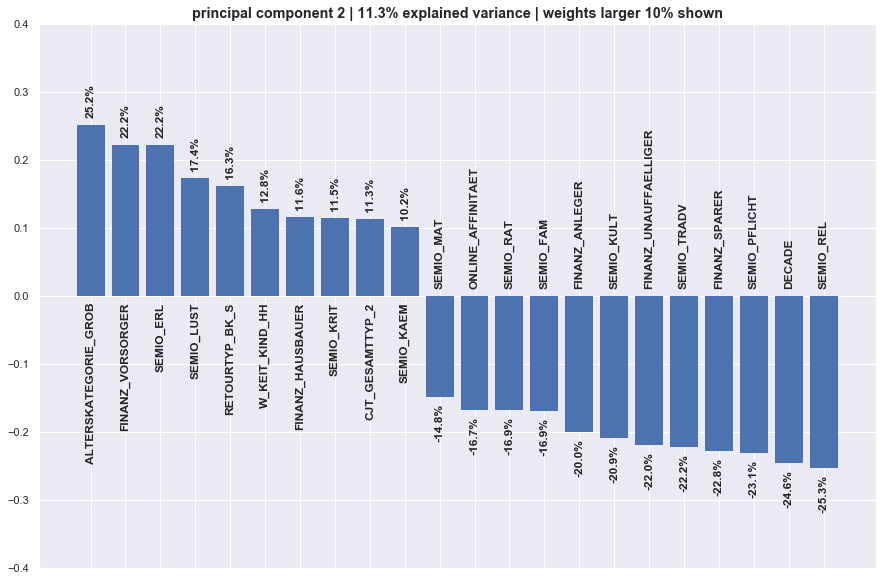

In [1017]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
plot_pca_weights(df_pca, 2)

> **PC2 analysis**

> **high positive weight**
* `ALTERSKLASSE_GROB`: ordinal, older individuals
* `FINANZ_VORSORGER`: ordinal, not preparing financially
* `SEMIO_ERL`: ordinal, not interested in events
* `SEMIO_LUST`: ordinal, not sensually-minded
* `RETOURTYP_BK_S`: categorical, conservative returners

> **high negative weight**
* `SEMIO_REL`: ordinal, religious
* `DECADE`: intervall, youth of the 1940s - 1960s
* `SEMIO_PFLICHT`: ordinal, dutiful
* `FINANZ_SPARER`: ordinal, tend to save money
* `SEMIO_TRADV`: ordinal, traditionally-minded
* `FINANZ_UNAUFFAELLIGER`: ordinal, financially incospicious
* `SEMIO_KULT`: ordinal, culturally-minded
* `FINANZ_ANLEGER`: ordinal, non-investors

> **Analysis:** Individuals with high PC2 values are **conservative, traditionally-minded, and religious eldery persons** who spent their **youth during the 1940s-1960s**. They are **dutiful** and **tend to save rather than invest money**.

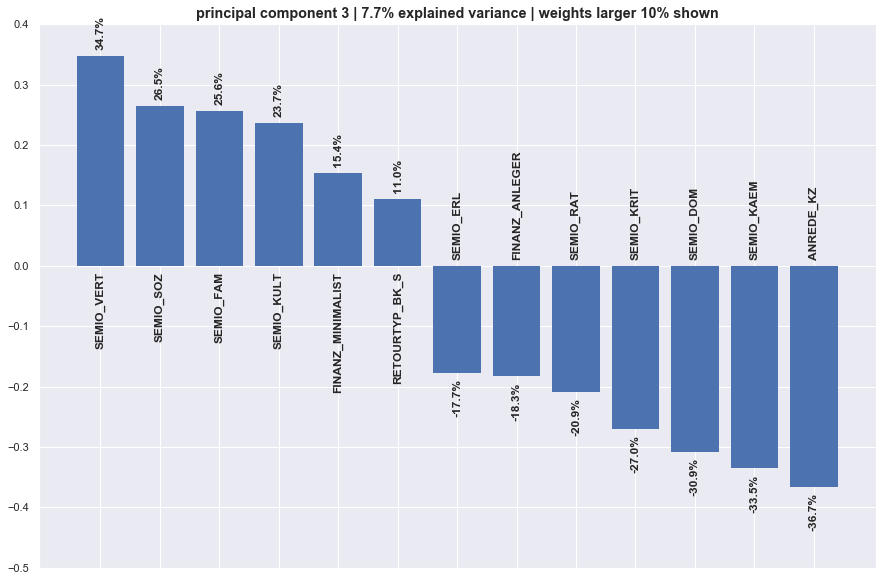

In [1018]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
plot_pca_weights(df_pca, 3)

> **PC3 analysis**

> **high positive weight**
* `SEMIO_VERT`: ordinal, not dreamful
* `SEMIO_SOZ`: ordinal, not socially-minded
* `SEMIO_FAM`: ordinal, not family-minded
* `SEMIO_KULT`: ordinal, not culturally interested
* `FINANZ_MINIMALIST`: categorical, financially active

> **high negative weight**
* `ANREDE_KZ`: ordinal, men
* `SEMIO_KAEM`: ordinal, combative attitude
* `SEMIO_DOM`: ordinal, dominant
* `SEMIO_KRIT`: ordinal, critical
* `SEMIO_RAT`: ordinal, rational
* `FINANZ_ANLEGER`: ordinal, investors
* `SEMIO_ERL`: ordinal, event-oriented

> **Analysis:** Individuals with high PC3 values are **dominant, critical, and rational men** with a **combative attitude**. They are **heavily interested** in **finances, investing, and events**.

> Compared to PC1 and PC2, PC3 has considerable higher weights which indicates that it maps the outline group well.

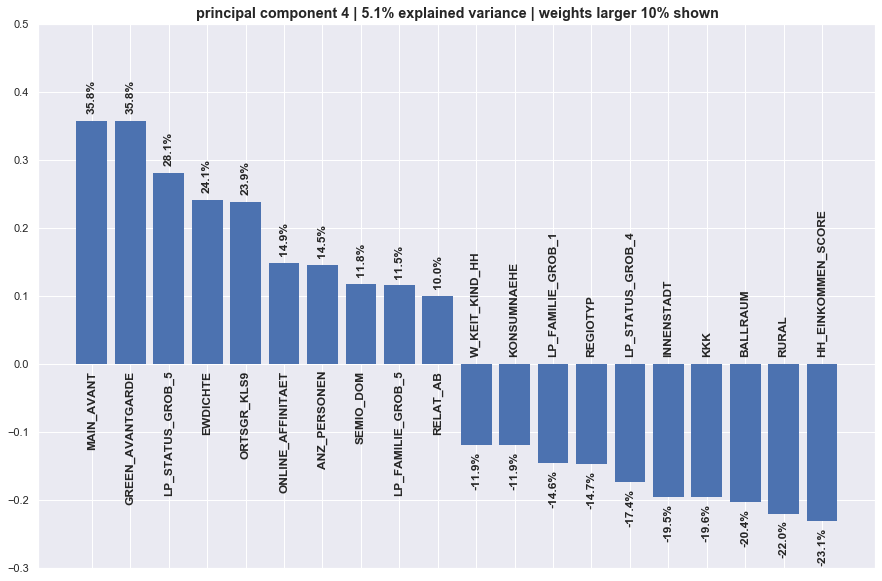

In [1019]:
# additional analysis of PC4 as it turned out to be relevant in the clustering analysis
plot_pca_weights(df_pca, 4)

> **PC4 analysis**

> **high positive weight**
* `MAIN_AVANT`: binary, avantgarde during youth
* `GREEN_AVANTGARD`: binary, green avantgard during youth
* `LP_STATUS_GROB_5`: ordinal, high income to top earners
* `EWDICHTE`: ordinal, high population density, 
* `ORTSGR_KLS9`: ordinal, large cities and communities, urban

> **high negative weight**
* `HH_EINKOMMEN_SCORE`: ordinal, high household income
* `RURAL`: ordinal, urban
* `BALLRAUM`: ordinal, close to urban centers
* `KKK`: ordinal, high purchasing power within region
* `INNENSTADT`: ordinal, close to city centers
* `LP_STATUS_GROB_4`: average, low incomes

> **Analysis:** Individuals with high PC4 values are **(green) avantgarde, mostly top-earners or with high household income** that live in **large urban communities** and **close to the city center**. They can be describe as **professionals**.

> Compared to PC1 and PC2, PC4 has considerable higher weights which indicates that it maps the outline group well.

### Discussion 2.3: Interpret Principal Components

> The analysis of the principal components (see above) shows that they map distinct groups in the general population incredibly well. The first three princial components, which explain one-third of the variance in the data, map to the poor metropolitan population, eldery people, and agressive male investors. Further analysis of the remaining prinicpal components is expected to identify more groups in the population. If needed to identify customers in the clustering, the analysis of other principal components will be done later.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [727]:
from sklearn.cluster import KMeans

clusters = range(2,21)
scores = np.zeros_like(clusters)

# Over a number of different cluster counts...
for i, clst in enumerate(clusters):
    
    # run k-means clustering on the data and...
    print('Fitting KMeans with %i clusters...' % clst)
    kmeans = KMeans(n_clusters=clst)
    kmeans.fit(data_pca_20)
        
    # compute the average within-cluster distances.
    scores[i] = kmeans.score(data_pca_20)
    

Fitting KMeans with 2 clusters...
Fitting KMeans with 3 clusters...
Fitting KMeans with 4 clusters...
Fitting KMeans with 5 clusters...
Fitting KMeans with 6 clusters...
Fitting KMeans with 7 clusters...
Fitting KMeans with 8 clusters...
Fitting KMeans with 9 clusters...
Fitting KMeans with 10 clusters...
Fitting KMeans with 11 clusters...
Fitting KMeans with 12 clusters...
Fitting KMeans with 13 clusters...
Fitting KMeans with 14 clusters...
Fitting KMeans with 15 clusters...
Fitting KMeans with 16 clusters...
Fitting KMeans with 17 clusters...
Fitting KMeans with 18 clusters...
Fitting KMeans with 19 clusters...
Fitting KMeans with 20 clusters...


Text(0, 0.5, 'KMeans score')

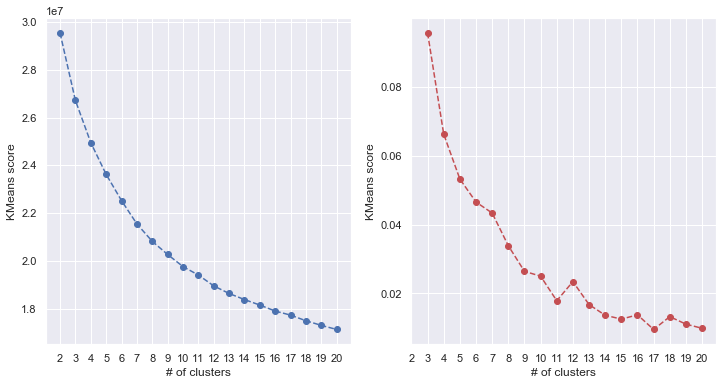

In [1020]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

# calculate relative change with increasing number of clusers
relative_change = -1.0*(scores[1:] - scores[0:-1])/scores[0:-1]


plt.figure(figsize=(12, 6))

# plot score vs. number of clusters
plt.subplot(1, 2, 1)
plt.plot(clusters, -1.0*scores, 'bo--')
plt.xticks(clusters)
plt.xlabel('# of clusters')
plt.ylabel('KMeans score')

# plot relative change vs. number of clusters
plt.subplot(1, 2, 2)
plt.plot(clusters[1:], relative_change, 'ro--')
plt.xticks(clusters)
plt.xlabel('# of clusters')
plt.ylabel('KMeans score')

In [1021]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

# re-fit with 8 clusters
kmeans = KMeans(n_clusters=8)
kmeans.fit(data_pca_20)

# get labels
labels_pca_20 = kmeans.labels_

### Discussion 3.1: Apply Clustering to General Population

> The KMeans clustering error (square distance) decreases only gradually with increasing number of clusters. For more than 8 clusters, however, the clustering error seems to decrease at a lower rate. This is confirmed by calculating the change of the clustering error with increasing number of clusters. Therefore, the 8 clusters are used for the subsequent analysis. 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [1022]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [1024]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

n_customer = customers.shape[0]

# data cleaning
customers_cleaned = clean_data(customers)

n_customer_cleaned = customers_cleaned.shape[0]
n_customer_missing = n_customer - n_customer_cleaned

print('%i (%.1f%%) incomplete rows in customer data after cleaning' % (n_customer_missing,
                                                                       n_customer_missing/n_customer*100.0))
# feature scaling
# check for missing values
print(customers_cleaned.isnull().sum().sum())
customers_std = scaler.transform(customers_cleaned)

# apply PCA
customers_pca_20 = pca_20.transform(customers_std)

# apply clustering
customers_labels = kmeans.predict(customers_pca_20)

# copy populations data and labels for consistent naming
population_pca_20 = data_pca_20.copy()
population_labels = labels_pca_20.copy()

76009 (39.7%) incomplete rows in customer data after cleaning
0


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [1025]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# create dataframes for predictions
df_population = pd.DataFrame(population_labels, columns=['LABELS_POP'])
df_customers = pd.DataFrame(customers_labels, columns=['LABELS_CUST'])

# get total number of datapoints in each set
n_pop = df_population.shape[0]
n_cust = df_customers.shape[0]

# create common dataframe for comparison
cluster_counts_pop = df_population['LABELS_POP'].value_counts(sort=False)
cluster_counts_cust = df_customers['LABELS_CUST'].value_counts(sort=False)

df_compare_pop = pd.DataFrame(cluster_counts_pop).reset_index()
df_compare_pop.rename(columns={'index': 'CLUSTER', 'LABELS_POP':'ABS_COUNTS'}, inplace=True)

df_compare_cust = pd.DataFrame(cluster_counts_cust).reset_index()
df_compare_cust.rename(columns={'index': 'CLUSTER', 'LABELS_CUST':'ABS_COUNTS'}, inplace=True)

df_compare = pd.concat([df_compare_pop, df_compare_cust], axis=0).reset_index()
df_compare.drop('index', axis=1, inplace=True)
df_compare['PROPORTION'] = 0
df_compare['DATASET'] = ''
df_compare['PROPORTION'].iloc[0:8] = np.array(cluster_counts_pop)/n_pop
df_compare['PROPORTION'].iloc[8:] = np.array(cluster_counts_cust)/n_cust
df_compare['DATASET'].iloc[0:8] = 'POPULATION'
df_compare['DATASET'].iloc[8:] = 'CUSTOMER'

/Users/larskiewidt/anaconda3/envs/datasci/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


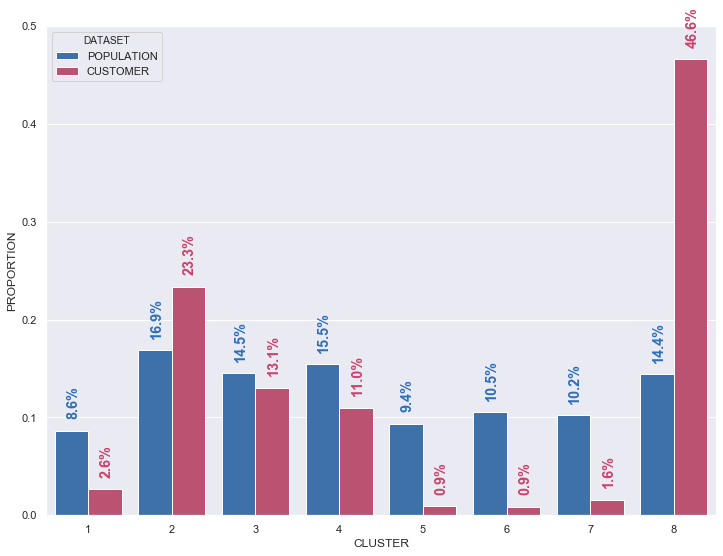

In [1026]:
# plot porportions
plt.figure(figsize=(12,9))
sns.barplot(data=df_compare, x='CLUSTER', y='PROPORTION', hue='DATASET',
            palette=[sns.xkcd_rgb['medium blue'], sns.xkcd_rgb['dark pink']])
plt.xticks(range(0,8), range(1,9))
plt.ylim(0.0, 0.5)
for i in range(8):
    plt.annotate('%.1f%%' % (df_compare['PROPORTION'].iloc[i]*100.0),
                 (i-0.18, df_compare['PROPORTION'].iloc[i]+0.015),
                 rotation=90, weight='bold', fontsize='large', ha='center',
                 color=sns.xkcd_rgb['medium blue'])
    plt.annotate('%.1f%%' % (df_compare['PROPORTION'].iloc[8+i]*100.0),
                 (i+0.22, df_compare['PROPORTION'].iloc[8+i]+0.015),
                 rotation=90, weight='bold', fontsize='large', ha='center',
                 color=sns.xkcd_rgb['dark pink'])


> **OBSERVATIONS**
* individuals belonging to cluster 8 or 2 are overrepresented in the customer dataset by factors of more than 3 and and 1.5, respectively.
    * individuals from these clusters are thus potential customers for the company
* individuals from clusters 5, 6, 7, and 1 are underrepresented in the customer dataset; the highest disparity is observed for clusters 6 and 7
* individuals from clusters 3 and 4 are fairly equally represented in both datasets

In [1027]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# create dataframe from labels and principal components for general population and customers
df_pop = df_population.join(pd.DataFrame(population_pca_20, columns=['PC%i' % val for val in range(1,21)]))
df_pop.rename(columns={'LABELS_POP': 'LABELS'}, inplace=True)

df_cust = df_customers.join(pd.DataFrame(customers_pca_20, columns=['PC%i' % val for val in range(1,21)]))
df_cust.rename(columns={'LABELS_CUST': 'LABELS'}, inplace=True)

In [1028]:
# get mean of principal components for over/underrepresented clusters (should be different from 0)

# cluster 8 (overrepresented)
print(df_cust[df_cust.LABELS == 7].mean())
print()

# cluster 2 (overrepresented)
print(df_cust[df_cust.LABELS == 1].mean())
print()

# cluster 6 (underrepresented)
print(df_cust[df_cust.LABELS == 5].mean())
print()

# cluster 7 (underrepresented)
print(df_cust[df_cust.LABELS == 6].mean())
print()

LABELS    7.000000
PC1      -4.279186
PC2       0.894804
PC3       2.064468
PC4       2.883356
PC5      -0.037912
PC6       0.013958
PC7       0.158159
PC8      -0.238012
PC9       0.404776
PC10     -0.296606
PC11      0.236398
PC12      0.263959
PC13      0.034773
PC14     -0.230720
PC15     -0.200045
PC16      0.502418
PC17     -0.105609
PC18     -0.125196
PC19      0.424160
PC20      0.018276
dtype: float64

LABELS    1.000000
PC1      -4.414032
PC2       0.603442
PC3       0.952804
PC4      -1.721976
PC5       0.832896
PC6       0.619025
PC7      -0.083990
PC8       0.356458
PC9       0.397307
PC10      0.988130
PC11     -0.095505
PC12     -0.295252
PC13      0.136605
PC14     -0.078069
PC15     -0.108663
PC16     -0.039246
PC17     -0.176042
PC18      0.429653
PC19     -0.299915
PC20     -0.207121
dtype: float64

LABELS    5.000000
PC1       4.307422
PC2      -0.400178
PC3      -2.257055
PC4       1.056998
PC5       0.194242
PC6      -0.082695
PC7       0.288334
PC8      -0.133287

> **OBSERVATIONS**
* **cluster 8 (overrepresented):**
    * low PC1 values
    * high PC4 values
    * high PC3 values
* **cluster 2 (overrepresented):**
    * low PC1 values
    * low PC4 values
* **cluster 6 (underrepresented):**
    * high PC1 values
    * high PC3 values
* **cluster 7 (underrepresented):**
    * low PC3 values
    * low PC2 values
    * lower PC1 values

### Discussion 3.3: Compare Customer Data to Demographics Data

> The analysis of the clusters shows that low PC1 values are overrepresented (clusters 8 and 2) in the customer data.  This points to older, dutiful, and traditionally-minded persons. The higher values of PC3 in cluster 1 shows that customers tend to have a more dominant, critical, and combative attitude. The high (cluster 8) and low (cluster 2) values of PC4 indicate that both, persons with high and low to average incomes, are customers.

> In the underepresented cluster 6, high values for PC1 dominate. This points to the younger urban population who lives in large apartment buildings and who generally have low household incomes. The lower values of PC2 (cluster 7) also point in this direction. The high values for PC3 (cluster 6) also indicate that men with agressive investment patters are also underrepresented in the customer dataset.

> During the cleaning procedure incomplete rows were removed from the dataset. The features of the removed rows point into the direction of wealthy, median age (40-50) persons, who do not belong to investors. Because of their high incomes and age, they could also be a potential cluster of customers.

> Potential customers segements for the mail-based sales company are thus older (50+), traditionally-minded, dutiful individuals. Young individuals with lower income living in urban environments are most likely not good candicates for an advertisment campaign. In both cases, the amount of removed rows was substantial: 30% in the population dataset and almost 40% in the customer dataset. The amount of removed data was thus significant compared to the amount of data in each cluster. Therefore, the influence of the removal of incomplete rows from both, the population and customer dataset, requires further investigation to obtain a more fine-grained picture of the customer segements.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.